In [19]:
%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx
from matplotlib import pyplot as plt


In [21]:
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub

# Load the Zachary Karate Club dataset
dataset = KarateClub()
data = dataset[0]


/Users/jkunz/Library/Caches/pypoetry/virtualenvs/cop-gnn-IZjXzcTC-py3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


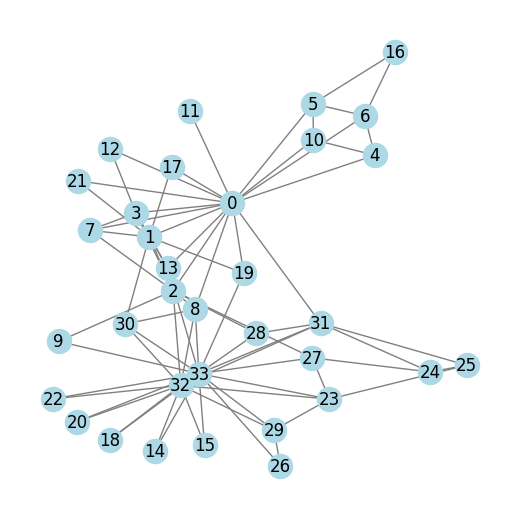

In [29]:
def plot_graph(G, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=True,
        node_color="lightblue",
        edge_color="gray",
        cmap="Set2",
    )


G = to_networkx(data, to_undirected=True)
# visualize(G, color=data.y)
# nx.draw(G, with_labels=True)
plot_graph(G, figsize=(5, 5))

In [35]:
num_nodes = data.num_nodes  # 34 nodes
edge_index = data.edge_index  # Edge list

# Construct adjacency matrix (without self-loops for neighborhood computation)
A = torch.zeros((num_nodes, num_nodes))
A[edge_index[0], edge_index[1]] = 1  # Undirected graph

edge_index[0], edge_index[1]
# matrix is symmetric
A[0,] == A[:, 0]


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

In [44]:
i = 0
j = 1
neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
neighbors_i
A[0].nonzero(as_tuple=True)[0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31])

In [37]:
# Compute Jaccard similarity matrix
def compute_jaccard_similarity(A):
    S = torch.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i, num_nodes):  # Symmetric matrix, compute upper triangle
            neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
            neighbors_j = set(A[j].nonzero(as_tuple=True)[0].tolist())
            intersection = len(neighbors_i & neighbors_j)
            union = len(neighbors_i | neighbors_j)
            if union > 0:  # Avoid division by zero
                sim = intersection / union
                S[i, j] = sim
                S[j, i] = sim  # Symmetry
    # No self-loops in Jaccard (typically similarity to self is not 1 unless defined)
    return S


S = compute_jaccard_similarity(A)
print("Jaccard similarity matrix sample:\n", S[:5, :5])


Jaccard similarity matrix sample:
 tensor([[1.0000, 0.3889, 0.2381, 0.2941, 0.1176],
        [0.3889, 1.0000, 0.2667, 0.3636, 0.0909],
        [0.2381, 0.2667, 1.0000, 0.3333, 0.0833],
        [0.2941, 0.3636, 0.3333, 1.0000, 0.1250],
        [0.1176, 0.0909, 0.0833, 0.1250, 1.0000]])


In [25]:
# Define the model with embedding lookup
class EmbeddingFactorization(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingFactorization, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_ids):
        Z = self.embedding(node_ids)
        return Z


# Set up model and optimizer
embedding_dim = 16
node_ids = torch.arange(num_nodes)
model = EmbeddingFactorization(num_nodes=num_nodes, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Get embeddings
    Z = model(node_ids)

    # Reconstructed similarity: Z Z^T
    S_hat = torch.matmul(Z, Z.t())

    # L2 (Frobenius) loss: ||Z Z^T - S||^2
    loss = torch.norm(S_hat - S, p="fro") ** 2

    # Backprop
    loss.backward()
    optimizer.step()
    return loss.item()


# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Get final embeddings
with torch.no_grad():
    Z = model(node_ids)
    print("Final embeddings shape:", Z.shape)
    print("Sample embeddings:\n", Z[:5])

# Evaluate reconstruction error
S_hat = torch.matmul(Z, Z.t())
reconstruction_error = torch.norm(S_hat - S, p="fro").item()
print(f"Final reconstruction error: {reconstruction_error:.4f}")

Epoch 0, Loss: 23642.7227
Epoch 20, Loss: 11602.5547
Epoch 40, Loss: 6288.5825
Epoch 60, Loss: 3811.3960
Epoch 80, Loss: 2514.5457
Epoch 100, Loss: 1759.7498
Epoch 120, Loss: 1284.9027
Epoch 140, Loss: 968.8372
Epoch 160, Loss: 749.2811
Epoch 180, Loss: 591.5223
Final embeddings shape: torch.Size([34, 16])
Sample embeddings:
 tensor([[-0.3532, -0.0957,  0.2559, -0.3507,  0.3049,  0.1693, -0.3434,  0.1798,
         -0.1807, -0.0640,  0.2188,  0.0799,  0.3373, -0.0232,  0.6217,  0.2325],
        [-0.0161, -0.0147,  0.3620, -0.3923,  0.0727,  0.0843, -0.1125, -0.3814,
         -0.1020, -0.2945,  0.2535,  0.0695,  0.0644, -0.1216,  0.0837,  0.0625],
        [ 0.2897, -0.1066, -0.0291, -0.0710, -0.1856, -0.9428,  0.0944,  0.0875,
         -0.0872, -0.1275,  0.0418, -0.0405,  0.1978,  0.0446, -0.4172, -0.0987],
        [ 0.9686,  0.6235,  0.0862,  0.1464, -0.3253,  0.0840, -0.0420,  0.4148,
         -0.1958, -0.1510,  0.3105, -0.0723,  0.4115, -0.0460,  0.2941,  0.2768],
        [ 0.2504, -0

In [17]:
# Load the Zachary Karate Club dataset
dataset = KarateClub()
data = dataset[0]  # Single graph
num_nodes = data.num_nodes  # 34 nodes
edge_index = data.edge_index  # Edge list

# Construct the similarity matrix S (adjacency matrix)
S = torch.zeros((num_nodes, num_nodes))
S[edge_index[0], edge_index[1]] = 1  # Undirected graph
S = S + torch.eye(num_nodes)  # Add self-loops (optional)


# Define the model with embedding lookup
class EmbeddingFactorization(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingFactorization, self).__init__()
        # Embedding layer: each node gets a unique embedding
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_ids):
        # Lookup embeddings for all nodes
        Z = self.embedding(node_ids)
        return Z


# Set up model and optimizer
embedding_dim = 16  # Embedding dimension
node_ids = torch.arange(num_nodes)  # Node indices [0, 1, ..., 33]
model = EmbeddingFactorization(num_nodes=num_nodes, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Get embeddings
    Z = model(node_ids)

    # Reconstructed similarity: Z Z^T
    S_hat = torch.matmul(Z, Z.t())

    # L2 (Frobenius) loss: ||Z Z^T - S||^2
    loss = torch.norm(S_hat - S, p="fro") ** 2

    # Backprop
    loss.backward()
    optimizer.step()
    return loss.item()


# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Get final embeddings
with torch.no_grad():
    Z = model(node_ids)
    print("Final embeddings shape:", Z.shape)
    print("Sample embeddings:\n", Z[:5])  # First 5 nodes

# Evaluate reconstruction error
S_hat = torch.matmul(Z, Z.t())
reconstruction_error = torch.norm(S_hat - S, p="fro").item()
print(f"Final reconstruction error: {reconstruction_error:.4f}")

Epoch 0, Loss: 31349.0488
Epoch 20, Loss: 16256.7090
Epoch 40, Loss: 9214.4258
Epoch 60, Loss: 5793.1211
Epoch 80, Loss: 3942.0808
Epoch 100, Loss: 2835.2307
Epoch 120, Loss: 2122.5625
Epoch 140, Loss: 1638.3839
Epoch 160, Loss: 1295.7561
Epoch 180, Loss: 1045.3267
Final embeddings shape: torch.Size([34, 16])
Sample embeddings:
 tensor([[ 1.1891, -0.6554,  0.3150, -0.2120, -0.1353, -0.0973, -0.1627, -0.5603,
         -0.1730,  0.1762,  0.2956, -0.1453,  0.0596, -0.9718,  0.2601, -0.3672],
        [-0.0604,  0.3826,  0.3026, -0.2847,  0.0025, -0.1528, -0.1496,  0.0244,
          0.0748,  0.8480, -0.1727, -0.0335,  0.5312, -0.4492,  0.8381,  0.7463],
        [-0.1293, -0.1207,  1.2876,  0.0579, -0.0902, -0.1808,  0.4375,  1.9356,
         -0.3006,  0.2868, -0.1242,  0.9487, -0.2708, -0.2260,  0.0160,  0.4128],
        [-0.0202, -0.3186, -0.0662, -1.0502, -0.0573, -0.0099, -0.0756, -0.0319,
          0.1766,  0.2578, -0.1232,  0.3660, -0.0986, -0.5536,  0.2396,  0.1637],
        [-0.0092,